# Food image classification model evaluation

 ## Summary
 
This notebook explores different model evaluation metrics to ascertain model performance.

**Confusion matrix results:**    
(800 total training samples: 400 positive, 400 negative)

- True Positive rate = 0.885
- True Negative rate = 0.873
- False Positive rate = 0.128
- False Negative rate = 0.115

**Performance metrics:**
- Accuracy = 0.88   
- Precision = 0.88
- Recall = 0.88
- F1-score = 0.88
- AUC = 0.94

All in all, the model performs decently well but not without shortcomings, namely overfitting and noisy data. Should we decide to further improve upon this model, collecting cleaner data (especially higher quality food image data), data augmentation, fine-tuning, and adjusting the learning rate during training, are all methods to experiment with to enhance the model's performance.

In [2]:
# install keras: 
# !pip install h5py
# !sed -i.bak '/run_tests/d' /usr/local/lib/python2.7/dist-packages/h5py/__init__.py
# !pip install keras

In [3]:
from glob import glob
from IPython.display import display
import numpy as np
from PIL import Image
import pandas as pd

from keras.models import load_model
from sklearn import metrics
from VGG16_feature_extractor import VGG16_feature_maps

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## Load previously trained classifier

The model architecture of two layers with 64 hidden units and 25% dropout yielded the model with the best balance of validation accuracy (88%) and complexity.

In [4]:
model_64_64 = load_model('model_files/model_64_64.hdf5')
model_64_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 528,577
Trainable params: 528,577
Non-trainable params: 0
_________________________________________________________________


## Validation feature maps
The feature maps for the validation dataset are recreated again using the `VGG16_feature_maps` function, but this time with `shuffle=False` in order to map filenames to predictions. When `shuffle` is turned off, predictions are in the same order as the pathname output from `ImageDataGenerator().flow_from_directory().filenames` (which is actually just the same as the output from `glob`). These feature maps are then saved to disk. After loading into memory, the feature maps are flattened to pass into our model for predictions.

In [5]:
validation_features_ordered = np.load('feature_maps/validation_features_ordered.npy')
validation_labels_ordered = np.load('feature_maps/validation_labels_ordered.npy')

validation_features_ordered = np.reshape(validation_features_ordered, (800, 4 * 4 * 512))
validation_features_ordered.shape, validation_labels_ordered.shape

((800, 8192), (800,))

## Prediction dataframe
Cast predictions and labels to a dataframe for easier manipulation.

In [6]:
def predictions_df(model, features, labels, filelist):
  predictions_dict = {'predicted_probability': list(model.predict_proba(features, verbose=0).flatten()),
                     'predicted_class': list(model.predict_classes(features, verbose=0).flatten()),
                     'true_class' : labels,
                     'filename' : filelist}
  predictions_df = pd.DataFrame(predictions_dict)
  predictions_df = predictions_df[['true_class', 'predicted_class', 'predicted_probability', 'filename']]
  predictions_df['true_label'] = predictions_df['true_class'].map(lambda x: 'Not food' if x == 0.0 else 'Food')
  predictions_df['predicted_label'] = predictions_df['predicted_class'].map(lambda x: 'Not food' if x == 0 else 'Food')
  return predictions_df

In [7]:
val_food = glob('Data Generation/Images/ImageNet clean/validation/food/*')
val_not_food = glob('Data Generation/Images/ImageNet clean/validation/not_food/*')
validation_filenames = val_not_food + val_food

val_predictions_df = predictions_df(model_64_64, validation_features_ordered, validation_labels_ordered, validation_filenames)
val_predictions_df.head(2)

,true_class,predicted_class,predicted_probability,filename,true_label,predicted_label
0,0.0,0,0.032065,Data Generation/Images/ImageNet clean/validati...,Not food,Not food
1,0.0,0,0.011798,Data Generation/Images/ImageNet clean/validati...,Not food,Not food


## Evaluation metrics

### Confusion matrix

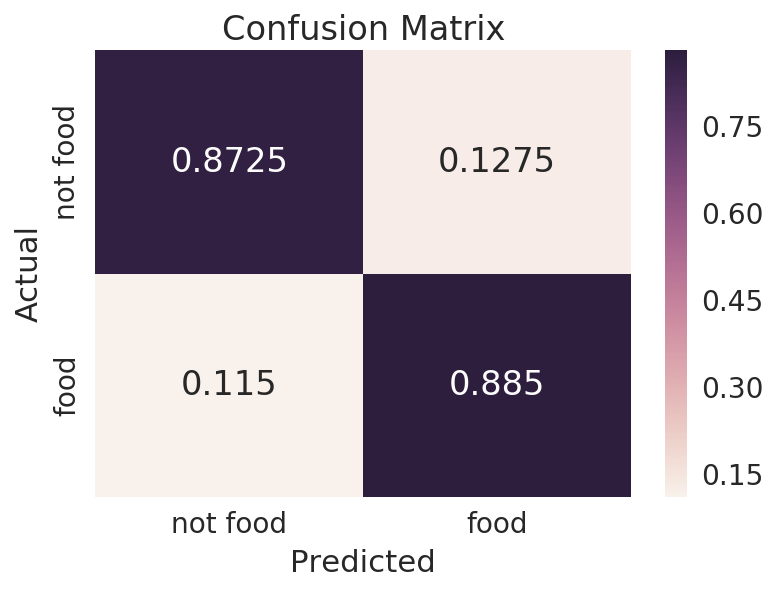

In [12]:
sns.set(font_scale=1.4)

def confusion_matrix_plot(true_class, predicted_probability, classes, normalize=False):
    plt.subplots(figsize=(6, 4))
    cm = metrics.confusion_matrix(true_class, predicted_probability,)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt='', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted'), plt.ylabel('Actual')
    plt.title('Confusion Matrix');

confusion_matrix_plot(val_predictions_df.true_class, val_predictions_df.predicted_class, ['not food', 'food'], normalize=True)

### Accuracy, Precision, Recall, F1-score

In [13]:
print('Accuracy: {0:.3f}'.format(float(sum(val_predictions_df.true_class == val_predictions_df.predicted_class))/val_predictions_df.shape[0]))

Accuracy: 0.879


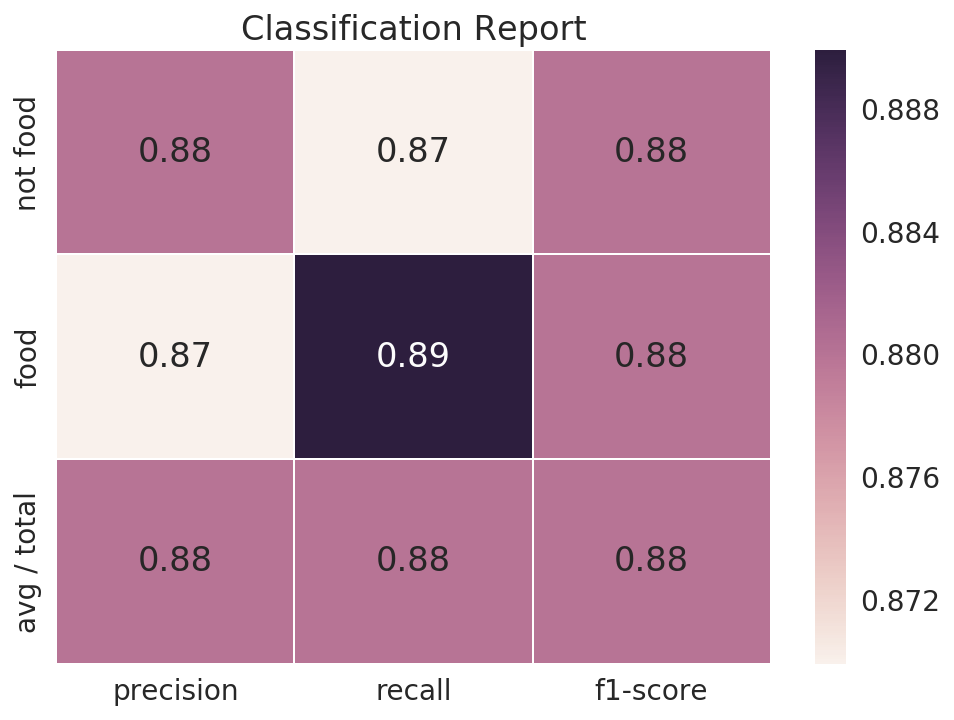

In [15]:
def classification_report_plot(true_class, predicted_probability):
    cr = metrics.classification_report(true_class, predicted_probability)
    nested_lst = [s.split() for i, s in enumerate(cr.split('\n')) if (i == 2) | (i == 3) | (i == 5)]
    clean_cr = [[float(x) for x in lst[-4:]][0:3] for lst in nested_lst]
    sns.heatmap(clean_cr, annot=True, linewidths=.5, 
              xticklabels=['precision', 'recall', 'f1-score'],
              yticklabels=['not food', 'food', 'avg / total']);
    plt.title('Classification Report');

classification_report_plot(val_predictions_df.true_class, val_predictions_df.predicted_class)

### ROC curve

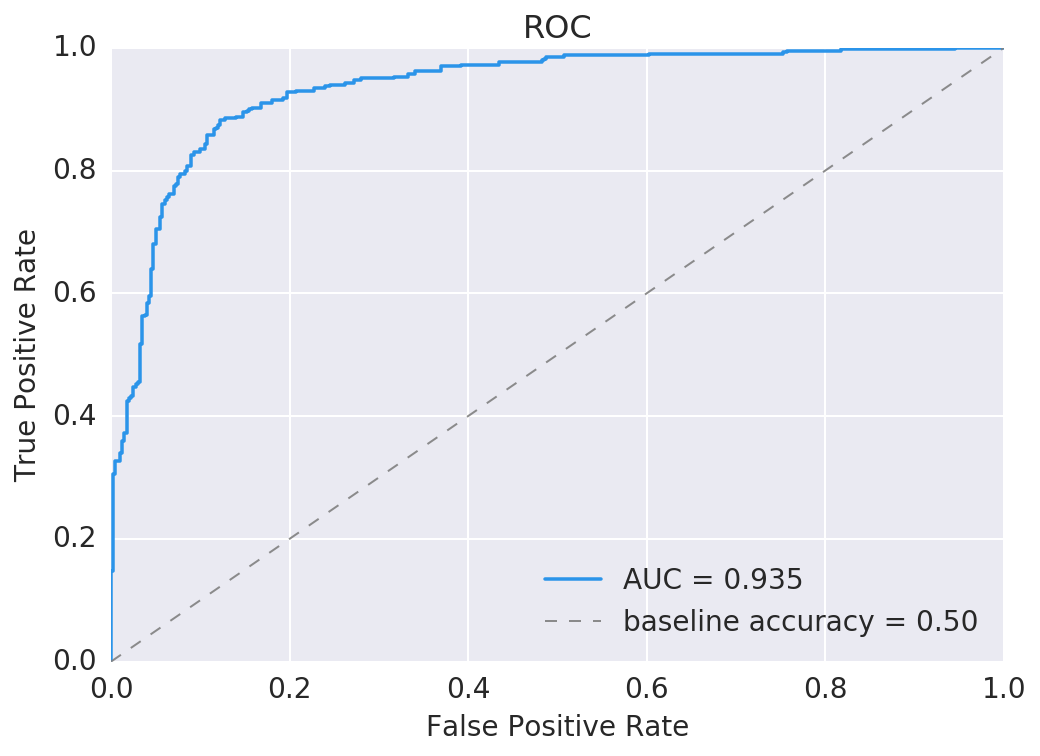

In [10]:
def plot_roc(true_class, predicted_probability, title='ROC'):
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(true_class, predicted_probability)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    baseline_acc = np.mean(true_class)

    plt.plot(false_positive_rate, true_positive_rate, '#2B94E9', label='AUC = %0.3f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=1, label='baseline accuracy = %0.2f' % baseline_acc)
    
    plt.title(title, fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right');

plot_roc(val_predictions_df.true_class, val_predictions_df.predicted_probability)

### Precision Recall curve 

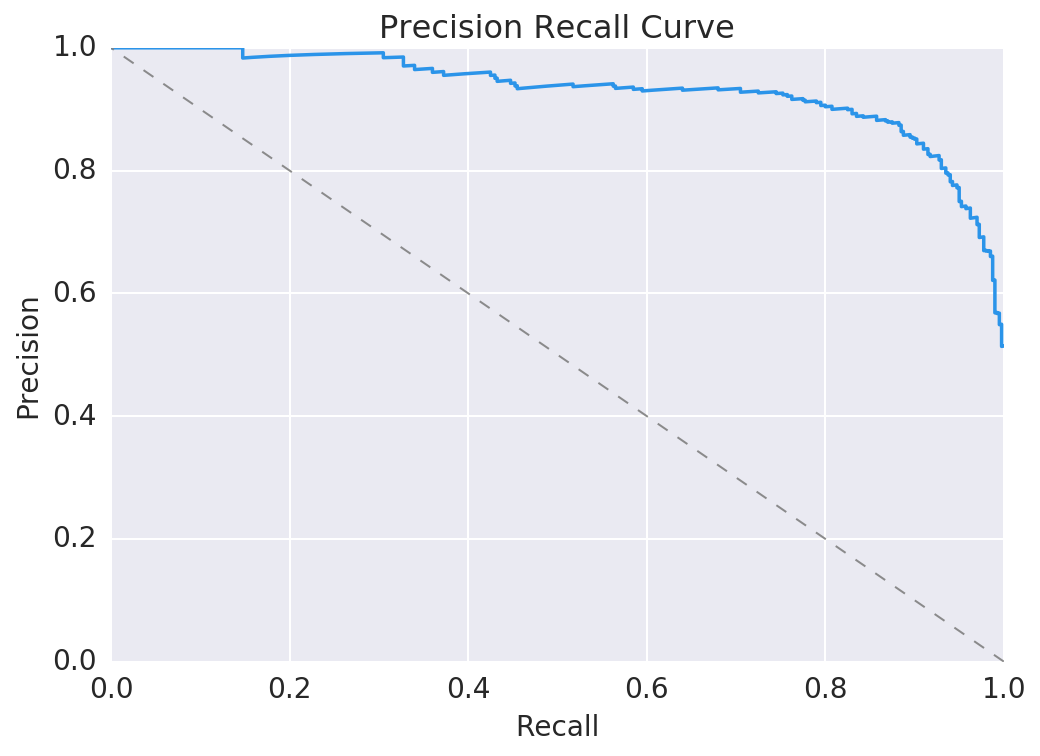

In [11]:
def plot_precision_recall(true_class, predicted_probability, title='Precision Recall Curve'):
    
    precision, recall, thresholds = metrics.precision_recall_curve(true_class, predicted_probability)

    plt.plot(recall, precision, '#2B94E9')
    plt.plot([1, 0], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=1)
    
    plt.title(title, fontsize=16)   
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14);

plot_precision_recall(val_predictions_df.true_class, val_predictions_df.predicted_probability)

### FPR & TPR analysis

In [12]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(val_predictions_df.true_class, val_predictions_df.predicted_probability)

roc_dict = {'false_positive_rate': [round(n, 3) for n in false_positive_rate],
            'true_positive_rate' : [round(n, 3) for n in true_positive_rate],
            'threshold': [round(n, 3) for n in thresholds]}

roc_df = pd.DataFrame(roc_dict)

roc_df['true_positives'] = roc_df['true_positive_rate'].map(lambda x: x * 400)
roc_df['false_positives'] = roc_df['false_positive_rate'].map(lambda x: x * 400)

roc_df[(roc_df.true_positives > 350) & (roc_df.false_positives < 50)].sort_values(by='threshold', ascending=False).head(20)

,false_positive_rate,threshold,true_positive_rate,true_positives,false_positives
79,0.122,0.502,0.882,352.8,48.8


In [13]:
def evaluate_fpr(fpr):
    return roc_df[roc_df.false_positive_rate >= fpr].sort_values(by='false_positive_rate').head()
evaluate_fpr(0.50)

,false_positive_rate,threshold,true_positive_rate,true_positives,false_positives
132,0.507,0.047,0.985,394.0,202.8
133,0.507,0.046,0.988,395.2,202.8
134,0.603,0.032,0.988,395.2,241.2
135,0.603,0.031,0.990,396.0,241.2
136,0.752,0.016,0.990,396.0,300.8


## Spot check predictions

In [52]:
def show_images(df):
    for idx in df.index.values:
        img = Image.open(df['filename'][idx])
        new_w = 150
        new_h = new_w * img.height / img.width
        img = img.resize((new_w, new_h), Image.ANTIALIAS)
        display(img)
        print("Prediction: {0} (raw probability = {1:.2f})\nTrue label: {2} ({3})".format(df['predicted_label'][idx],
                                df['predicted_probability'][idx], df['true_label'][idx], 
                                df['filename'][idx]))
        print('-------------------------------------------------------------------------------------------------')

### Correctly classified images

In [53]:
correct_mask = val_predictions_df.predicted_class == val_predictions_df.true_class
correct = val_predictions_df[correct_mask]
correct_not_food = correct.sort_values(['predicted_probability'], ascending=True)
correct_food = correct.sort_values(['predicted_probability'], ascending=False)

#### Images correctly labeled as not food
These are images the model correctly and very assuredly classifies as not food (with a raw probability of 0).

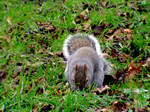

Prediction: Not food (raw probability = 0.00)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/367789162_ec9d5226de.jpg)
-------------------------------------------------------------------------------------------------


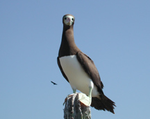

Prediction: Not food (raw probability = 0.00)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/sula.jpg)
-------------------------------------------------------------------------------------------------


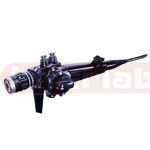

Prediction: Not food (raw probability = 0.00)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/692071.jpg)
-------------------------------------------------------------------------------------------------


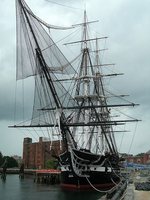

Prediction: Not food (raw probability = 0.00)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/1087725385_01ee15254a.jpg)
-------------------------------------------------------------------------------------------------


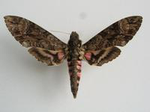

Prediction: Not food (raw probability = 0.00)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/1208569785-t.jpg)
-------------------------------------------------------------------------------------------------


In [54]:
show_images(correct_not_food[:5])

#### Images correctly labeled as food
These are images the model correctly and very assuredly classifies as food (with a raw probability of 1).

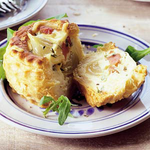

Prediction: Food (raw probability = 1.00)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/000457488_001_FRAL07120372_300.jpg)
-------------------------------------------------------------------------------------------------


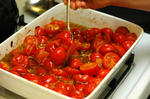

Prediction: Food (raw probability = 1.00)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/2454322383_272fe810cf.jpg)
-------------------------------------------------------------------------------------------------


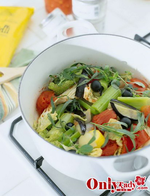

Prediction: Food (raw probability = 1.00)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/151.jpg)
-------------------------------------------------------------------------------------------------


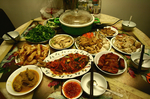

Prediction: Food (raw probability = 1.00)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/2254694132_5109c098c7.jpg)
-------------------------------------------------------------------------------------------------


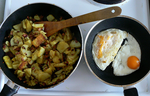

Prediction: Food (raw probability = 1.00)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/2493519699_1454cea2a6.jpg)
-------------------------------------------------------------------------------------------------


In [55]:
show_images(correct_food[:5])

### Misclassified images

In [18]:
incorrect_mask = val_predictions_df.predicted_class != val_predictions_df.true_class
incorrect = val_predictions_df[incorrect_mask]

incorrect_not_food = incorrect.sort_values(['predicted_probability'], ascending=True)
incorrect_food = incorrect.sort_values(['predicted_probability'], ascending=False)

#### Images incorrectly labeled as not food
These are images the model _incorrectly_ but still very assuredly classifies as not food (with a raw probability near or at 0).

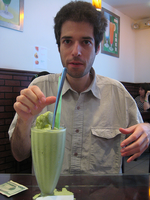

Prediction: Not food (p = 0.00)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/2745719370_7a5f535091.jpg)
-------------------------------------------------------------------------------------------------


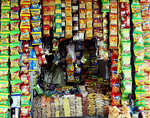

Prediction: Not food (p = 0.01)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/3342070996_68a2a5cd82.jpg)
-------------------------------------------------------------------------------------------------


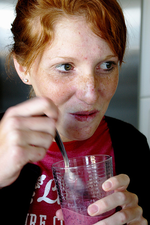

Prediction: Not food (p = 0.02)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/149161508_ce9c12d2ca.jpg)
-------------------------------------------------------------------------------------------------


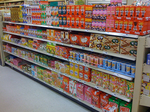

Prediction: Not food (p = 0.02)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/4105950153_6aac25b175.jpg)
-------------------------------------------------------------------------------------------------


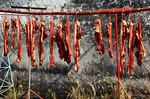

Prediction: Not food (p = 0.03)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/3172940715_a5b16d69e9.jpg)
-------------------------------------------------------------------------------------------------


In [19]:
show_images(incorrect_not_food[:5])

#### Images incorrectly labeled as food
These are images the model _incorrectly_ but still very assuredly classifies as food (with a raw probability near or at 1). Note these images are indeed labeled as not food, when they are in fact clearly food images. This was a shortcoming of the data collection process, as some food images were unavoidably randomly sampled from ImageNet to build the not food training set. On the bright side, the model does actually correctly label them as food images, although not "officially".

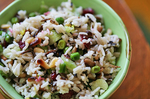

Prediction: Food (p = 0.99)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/2676418440_ebd19f595e.jpg)
-------------------------------------------------------------------------------------------------


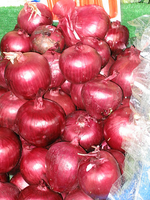

Prediction: Food (p = 0.97)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/6281147_b6e505dfd0.jpg)
-------------------------------------------------------------------------------------------------


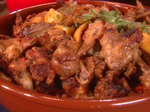

Prediction: Food (p = 0.97)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/FO1C10_16637_s4x3_lg.jpg)
-------------------------------------------------------------------------------------------------


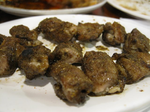

Prediction: Food (p = 0.97)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/IMG_0598.JPG)
-------------------------------------------------------------------------------------------------


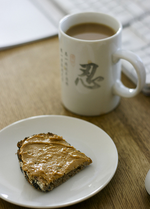

Prediction: Food (p = 0.97)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/3586017787_77a85ff0d7.jpg)
-------------------------------------------------------------------------------------------------


In [20]:
show_images(incorrect_food[:5])

### Images the model is most uncertain about

In [21]:
unsure_correct_mask = (val_predictions_df.predicted_probability.between(0.49, 0.51)) & (val_predictions_df.predicted_class == val_predictions_df.true_class)
unsure_correct = val_predictions_df[unsure_correct_mask].sort_values(['predicted_probability'], ascending=True)

unsure_incorrect_mask = (val_predictions_df.predicted_probability.between(0.45, 0.55)) & (val_predictions_df.predicted_class != val_predictions_df.true_class)
unsure_incorrect = val_predictions_df[unsure_incorrect_mask].sort_values(['predicted_probability'], ascending=True)

#### Images correctly labeled 
These are images the model correctly classifies as food but only very narrowly (as the raw probabilities are near or at the 0.5 class boundary threshold).

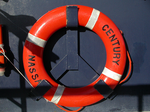

Prediction: Not food (p = 0.49)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/1014618105_1ded90a631.jpg)
-------------------------------------------------------------------------------------------------


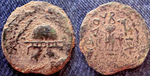

Prediction: Not food (p = 0.49)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/herod-coin-10169.jpg)
-------------------------------------------------------------------------------------------------


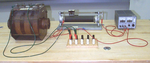

Prediction: Not food (p = 0.50)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/5j2030.jpg)
-------------------------------------------------------------------------------------------------


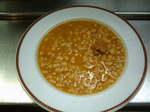

Prediction: Food (p = 0.50)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/54102257_fa1f6e07fa.jpg)
-------------------------------------------------------------------------------------------------


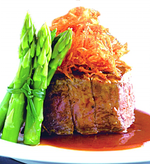

Prediction: Food (p = 0.50)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/10478356_573067.jpg)
-------------------------------------------------------------------------------------------------


In [22]:
show_images(unsure_correct[:5])

#### Images incorrectly labeled
The flip side of the case above, these are images the model incorrectly classifies as not food but again only very narrowly (as the raw probabilities are at or near the 0.5 class boundary threshold).

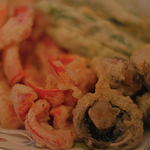

Prediction: Not food (p = 0.47)
True label: Food (Data Generation/Images/ImageNet clean/validation/food/4232085942_7e14fee231.jpg)
-------------------------------------------------------------------------------------------------


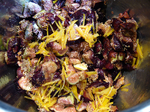

Prediction: Food (p = 0.50)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/3723959523_84647e805e.jpg)
-------------------------------------------------------------------------------------------------


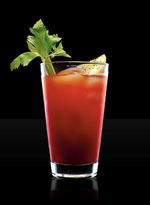

Prediction: Food (p = 0.50)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/absolut-bloody-mary.jpg)
-------------------------------------------------------------------------------------------------


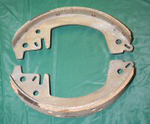

Prediction: Food (p = 0.52)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/8.040shoes.jpg)
-------------------------------------------------------------------------------------------------


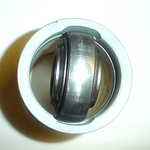

Prediction: Food (p = 0.54)
True label: Not food (Data Generation/Images/ImageNet clean/validation/not_food/gimbalbrga4.jpg)
-------------------------------------------------------------------------------------------------


In [25]:
show_images(unsure_incorrect[:5])

# Examine hold out data

# Hold out 1
This very small hold out data consists of wellio recipe images that are not food. These are often placeholder images from recipe sources that do not have accompanying recipe images. Others are generally from poor quality recipe sources where users can upload non food images to accompany their recipes. 

## Create feature maps & predictions

In [17]:
holdout1_features, holdout1_labels = VGG16_feature_maps(27, 'Data Generation/Images/holdout/', 1, class_list=['holdout1'], shuffle=False)

Found 22 images belonging to 1 classes.
{'holdout1': 0}


In [18]:
holdout1_features = np.reshape(holdout1_features, (27, 4 * 4 * 512))
holdout1_features.shape, holdout1_labels.shape

((27, 8192), (27,))

In [19]:
holdout1_predictions_df = predictions_df(model_64_64, holdout1_features, holdout1_labels, glob('Data Generation/Images/holdout/holdout1/*'))
holdout1_predictions_df.head()

,true_class,predicted_class,predicted_probability,filename,true_label,predicted_label
0,0.0,0,0.005508,Data Generation/Images/holdout/holdout1/app.ge...,Not food,Not food
1,0.0,0,0.021600,Data Generation/Images/holdout/holdout1/app.ge...,Not food,Not food
2,0.0,0,0.003398,Data Generation/Images/holdout/holdout1/recipe...,Not food,Not food
3,0.0,0,0.064496,Data Generation/Images/holdout/holdout1/app.ge...,Not food,Not food
4,0.0,0,0.340056,Data Generation/Images/holdout/holdout1/recipe...,Not food,Not food


## Evaluation metrics

### Confusion matrix

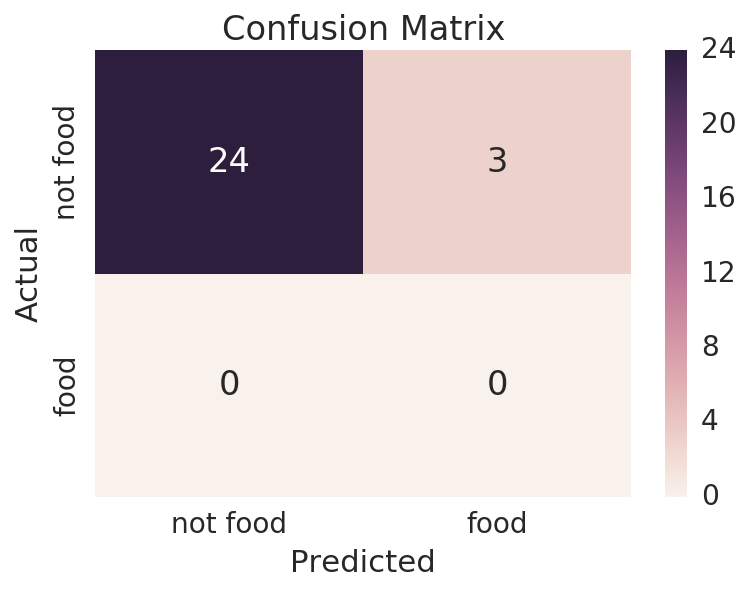

In [21]:
confusion_matrix_plot(holdout1_predictions_df.true_class, holdout1_predictions_df.predicted_class, ['not food', 'food'])

### Accuracy, Precision, Recall, F1-score

In [28]:
print('Accuracy: {0:.3f}'.format(float(sum(holdout1_predictions_df.true_class == holdout1_predictions_df.predicted_class))/holdout1_predictions_df.shape[0]))

Accuracy: 0.889


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


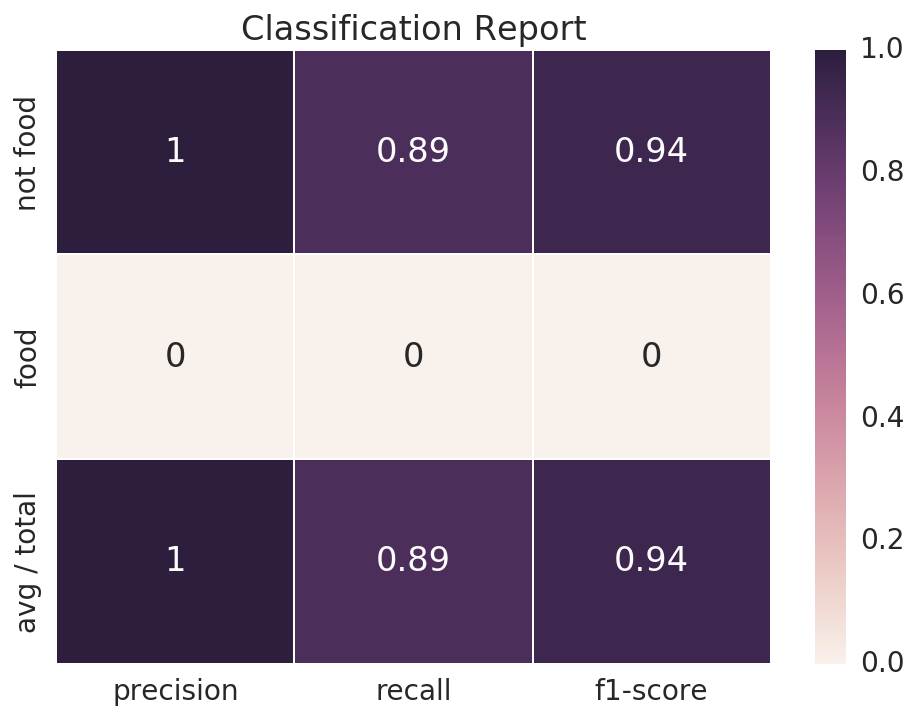

In [29]:
classification_report_plot(holdout1_predictions_df.true_class, holdout1_predictions_df.predicted_class)

## Spot check predictions

### Correctly classified images

#### Images correctly labeled as not food
These are images the model correctly and very assuredly classifies as not food.

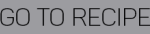

Prediction: Not food (raw probability = 0.00)
True label: Not food (Data Generation/Images/holdout/holdout1/_?h=150&m=crop&u=https%3A%2F%2Fstorage.googleapis.com%2Fassets.getwellio.com%2Fapp.getwellio.com%252Frecipe-images%252F6285cd3ecfc5f522a6b499d950c7b39ba421b436&w=150&s=b%27AWpPRO9PhZOkDZODCHa_2Vj0Tcg%27)
-------------------------------------------------------------------------------------------------


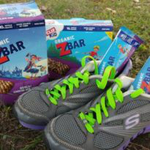

Prediction: Not food (raw probability = 0.00)
True label: Not food (Data Generation/Images/holdout/holdout1/recipe-images%2F87f07ae5a3072298f028212593c0bbb0a44efbaf)
-------------------------------------------------------------------------------------------------


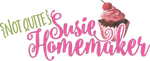

Prediction: Not food (raw probability = 0.00)
True label: Not food (Data Generation/Images/holdout/holdout1/app.getwellio.com%2Frecipe-images%2Fc69a2df91b32ba82b584ee799a3c67264aab5176.png)
-------------------------------------------------------------------------------------------------


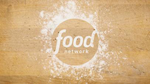

Prediction: Not food (raw probability = 0.01)
True label: Not food (Data Generation/Images/holdout/holdout1/app.getwellio.com%2Frecipe-images%2F1b11f6fe87a23ec5c51a07792a9fe3295fe7ff04)
-------------------------------------------------------------------------------------------------


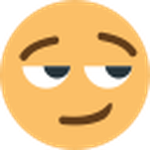

Prediction: Not food (raw probability = 0.01)
True label: Not food (Data Generation/Images/holdout/holdout1/app.getwellio.com%2Frecipe-images%2Ff388d638507a3a19995fd5e1144365e0923b6df5.png)
-------------------------------------------------------------------------------------------------


In [58]:
correct_holdout1_mask = holdout1_predictions_df.predicted_class == holdout1_predictions_df.true_class
correct_holdout1 = holdout1_predictions_df[correct_holdout1_mask]
correct_holdout1_not_food = correct_holdout1.sort_values(['predicted_probability'], ascending=True)
show_images(correct_holdout1_not_food[:5])

### Misclassified images

#### Images incorrectly labeled as food
These are the only three images the model incorrectly classifies and interestingly enough none are actually of food (though food related). On a positive note, two of the three are near the 0.5 class boundary threshold.

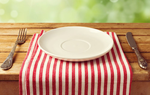

Prediction: Food (raw probability = 0.77)
True label: Not food (Data Generation/Images/holdout/holdout1/app.getwellio.com%2Frecipe-images%2F93b5d81f6a84e3a01c77a1b70a264ab2d08e9b04.jpg)
-------------------------------------------------------------------------------------------------


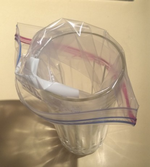

Prediction: Food (raw probability = 0.54)
True label: Not food (Data Generation/Images/holdout/holdout1/piczrvjNr.jpg)
-------------------------------------------------------------------------------------------------


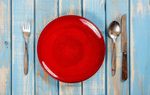

Prediction: Food (raw probability = 0.54)
True label: Not food (Data Generation/Images/holdout/holdout1/app.getwellio.com%2Frecipe-images%2F5847b0e6bd594e50169adae091b3f35b197ab14c.jpg)
-------------------------------------------------------------------------------------------------


In [59]:
incorrect_holdout1_mask = holdout1_predictions_df.predicted_class != holdout1_predictions_df.true_class
incorrect_holdout1 = holdout1_predictions_df[incorrect_holdout1_mask]
incorrect_holdout1_food = incorrect_holdout1.sort_values(['predicted_probability'], ascending=False)
show_images(incorrect_holdout1_food)

### Images the model is uncertain about

#### Images correctly labeled
These are images the model correctly classifies as not food but is not as sure about (the raw probabilities are around 0.35). Note technically two of the below images are actually of food, but these are precisely the kind of images we want the model to filter out.

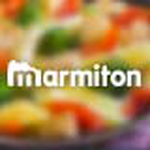

Prediction: Not food (raw probability = 0.35)
True label: Not food (Data Generation/Images/holdout/holdout1/recipe-images%2F3259c8a901e1d9d15de2060e80387616d77737fe.jpg)
-------------------------------------------------------------------------------------------------


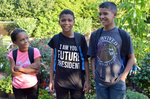

Prediction: Not food (raw probability = 0.34)
True label: Not food (Data Generation/Images/holdout/holdout1/recipe-images%2F3183ce6d920515ef84a9f4d50eed9df0f9bed555.jpg)
-------------------------------------------------------------------------------------------------


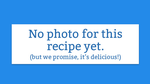

Prediction: Not food (raw probability = 0.34)
True label: Not food (Data Generation/Images/holdout/holdout1/app.getwellio.com%2Frecipe-images%2F7ef41c52ecabca9c4967c0233cb85ee81d2dcd87)
-------------------------------------------------------------------------------------------------


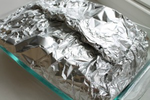

Prediction: Not food (raw probability = 0.33)
True label: Not food (Data Generation/Images/holdout/holdout1/recipe-images%2Fdd47239b9a26dea14703d1e35970557505b104d7.jpg)
-------------------------------------------------------------------------------------------------


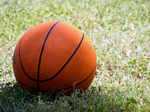

Prediction: Not food (raw probability = 0.33)
True label: Not food (Data Generation/Images/holdout/holdout1/recipe-images%2F3b0dd7356557b77f087dab54e316fc37b509578e.jpg)
-------------------------------------------------------------------------------------------------


In [60]:
unsure_ho1dout1_mask = (holdout1_predictions_df.predicted_probability > 0.3) & (holdout1_predictions_df.predicted_class == holdout1_predictions_df.true_class)
unsure_ho1dout1 = holdout1_predictions_df[unsure_ho1dout1_mask].sort_values(['predicted_probability'], ascending=False)
show_images(unsure_ho1dout1[:5])

# Hold out 2
Again, this is a very small hold out of wellio recipe images that are of food but are visually unappealing. Similar to hold out 1, these are generally from poor quality recipe sources where users upload amateurish/phone quality food images to accompany their recipes. Although this model is not trained to detect them (the food images in the training set are of mixed quality), it's still interesting to see what the model makes of them. 

Due to the way Keras has implemented inferring classes from directory structure, the below analysis assigns class 0 to this data. In a way, this is actually not so bad, as we'd like the model to classify them as not food anyway.

## Create feature maps & predictions

In [36]:
holdout2_features, holdout2_labels = VGG16_feature_maps(21, 'Data Generation/Images/holdout/', 1, class_list=['holdout2'], shuffle=False)

Found 20 images belonging to 1 classes.
{'holdout2': 0}


In [37]:
holdout2_features = np.reshape(holdout2_features, (21, 4 * 4 * 512))
holdout2_features.shape, holdout2_labels.shape

((21, 8192), (21,))

In [38]:
holdout2_predictions_df = predictions_df(model_64_64, holdout2_features, holdout2_labels, glob('Data Generation/Images/holdout/holdout2/*'))
holdout2_predictions_df.head()

,true_class,predicted_class,predicted_probability,filename,true_label,predicted_label
0,0.0,0,0.105443,Data Generation/Images/holdout/holdout2/app.ge...,Not food,Not food
1,0.0,0,0.396990,Data Generation/Images/holdout/holdout2/app.ge...,Not food,Not food
2,0.0,1,0.814411,Data Generation/Images/holdout/holdout2/app.ge...,Not food,Food
3,0.0,1,0.962770,Data Generation/Images/holdout/holdout2/app.ge...,Not food,Food
4,0.0,0,0.270048,Data Generation/Images/holdout/holdout2/380a4f...,Not food,Not food


## Evaluation Metrics

### Confusion matrix

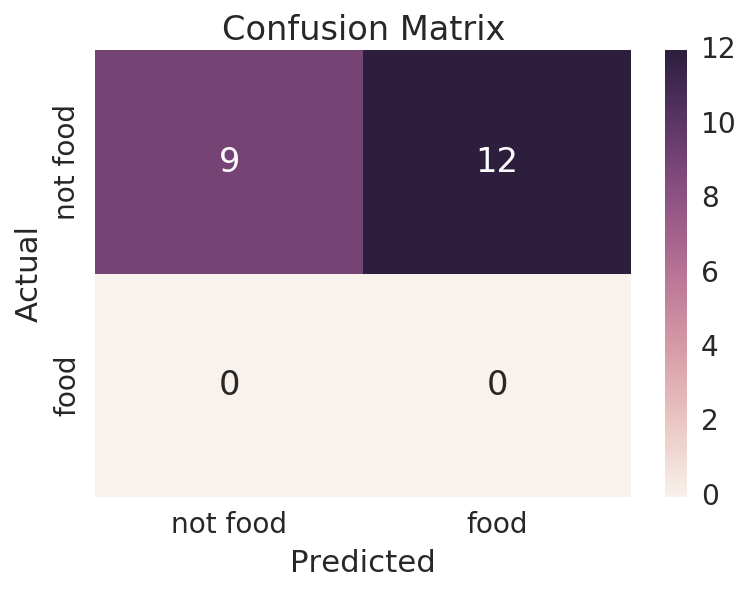

In [39]:
confusion_matrix_plot(holdout2_predictions_df.true_class, holdout2_predictions_df.predicted_class, ['not food', 'food'])

### Accuracy, Precision, Recall, F1-score

In [40]:
print('Accuracy: {0:.3f}'.format(float(sum(holdout2_predictions_df.true_class == holdout2_predictions_df.predicted_class))/holdout2_predictions_df.shape[0]))

Accuracy: 0.429


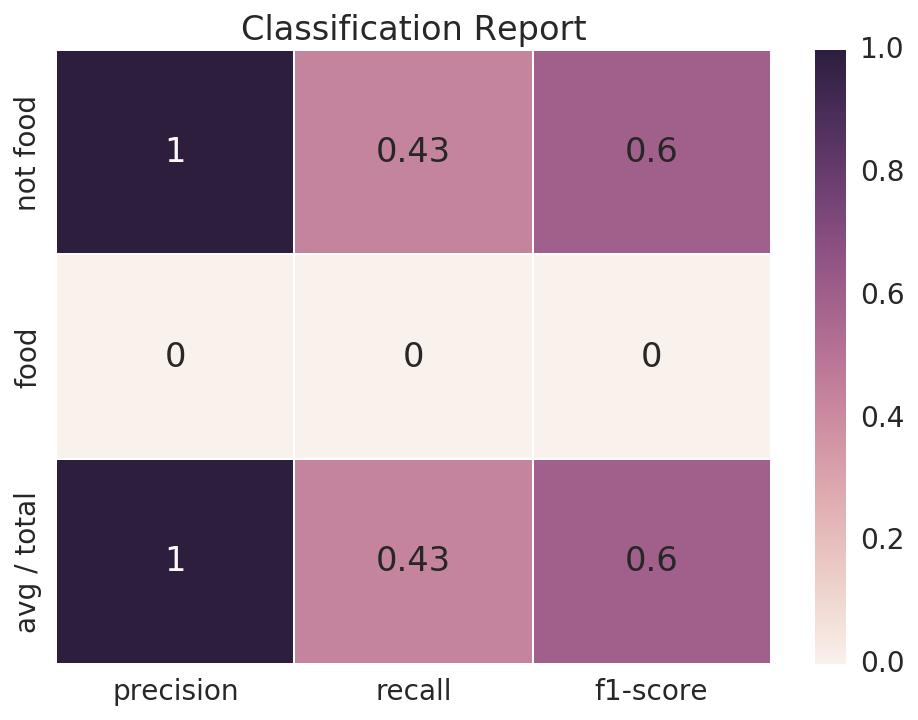

In [41]:
classification_report_plot(holdout2_predictions_df.true_class, holdout2_predictions_df.predicted_class)

## Spot check predictions

### Correctly classified images

#### Images correctly labeled as not food
These are images the model classifies as not food, which is technically incorrect, but this should make us happy in regards to weeding out unappealing images. And yes, the third image is suppose to look that way... it's a recipe for [Cat Poop Cookies](https://wellio.getwellio.com/recipes/00d1cc13851e6876ded4537c54ff0a4a). Also the fourth image does indeed appear in that orientation on wellio.

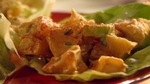

Prediction: Not food (raw probability = 0.06)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F2f4f08e81901cee126e998fdb0502d0f629a1a50.jpg)
-------------------------------------------------------------------------------------------------


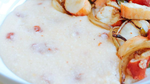

Prediction: Not food (raw probability = 0.11)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F161124a3544d922fe2df1ba6186c827a340399b6.jpg)
-------------------------------------------------------------------------------------------------


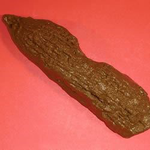

Prediction: Not food (raw probability = 0.11)
True label: Not food (Data Generation/Images/holdout/holdout2/recipe-images%2F23a440f39c64efd031426821a222617b63892f8a.jpg)
-------------------------------------------------------------------------------------------------


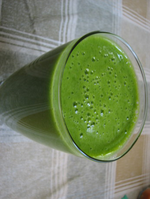

Prediction: Not food (raw probability = 0.22)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F0e75e04d973157364698f7adfad562fe0dd4f884.jpg)
-------------------------------------------------------------------------------------------------


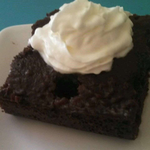

Prediction: Not food (raw probability = 0.27)
True label: Not food (Data Generation/Images/holdout/holdout2/380a4fed-6700-43ff-a7db-0f7b7fbb478b.jpg)
-------------------------------------------------------------------------------------------------


In [62]:
correct_holdout2_mask = holdout2_predictions_df.predicted_class == holdout2_predictions_df.true_class
correct_holdout2 = holdout2_predictions_df[correct_holdout2_mask]
correct_holdout1_not_food = correct_holdout2.sort_values(['predicted_probability'], ascending=True)
show_images(correct_holdout1_not_food[:5])

### Misclassified images

#### Images correctly labeled as food but we wish they were not
These are images the model classifies as food which is disappointing because they are all awful looking, but especially because we'd like to filter out images with text overlays like the third image (and to some extent, the first one too).

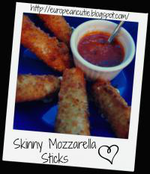

Prediction: Food (raw probability = 0.96)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F7948a46a91bf895a526ad56ea310df39179dd953.jpg)
-------------------------------------------------------------------------------------------------


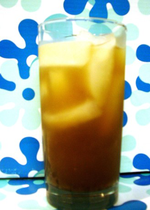

Prediction: Food (raw probability = 0.93)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F497d7854a477dedf6ad21c5e9e3902639faf9494.jpg)
-------------------------------------------------------------------------------------------------


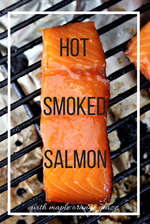

Prediction: Food (raw probability = 0.91)
True label: Not food (Data Generation/Images/holdout/holdout2/recipe-images%2F52db7ea0d401e95b48a1990d1efd56161d121045)
-------------------------------------------------------------------------------------------------


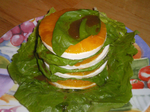

Prediction: Food (raw probability = 0.90)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F836c2d70ecd5a965da5704222990b111b6e2e936.jpg)
-------------------------------------------------------------------------------------------------


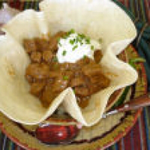

Prediction: Food (raw probability = 0.88)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F1119bbc0ca6a6dc1cf1c5fbf90855191482c3a56.jpg)
-------------------------------------------------------------------------------------------------


In [63]:
incorrect_holdout2_mask = holdout2_predictions_df.predicted_class != holdout2_predictions_df.true_class
incorrect_holdout2 = holdout2_predictions_df[incorrect_holdout2_mask]
incorrect_holdout2_food = incorrect_holdout2.sort_values(['predicted_probability'], ascending=False)
show_images(incorrect_holdout2_food[:5])

### Images the model is uncertain about

#### Images correctly labeled
These are images the model is right not to call food! But the raw probability scores are near the 0.5 class boundary, so it's a bit unsure. 

And oh look, another [Cat Poop Cookies](https://wellio.getwellio.com/recipes/a987e66f-3618-4e07-8fde-19845788fd5d) recipe... we should feel good knowing the model doesn't classify images of such aptly named cookies as food!

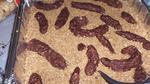

Prediction: Not food (raw probability = 0.45)
True label: Not food (Data Generation/Images/holdout/holdout2/recipe-images%2Fc0cea29d0c1cefaf46cf8e0abaa8b89548167675.jpg)
-------------------------------------------------------------------------------------------------


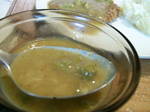

Prediction: Not food (raw probability = 0.43)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F64dfffc55a11201e2d9f229b78bac53ce07efd12.jpg)
-------------------------------------------------------------------------------------------------


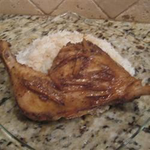

Prediction: Not food (raw probability = 0.40)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F917673f67bdfa4ab5a4864d672594b6d6b7a9e1d.jpg)
-------------------------------------------------------------------------------------------------


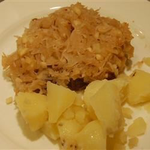

Prediction: Not food (raw probability = 0.33)
True label: Not food (Data Generation/Images/holdout/holdout2/app.getwellio.com%2Frecipe-images%2F5c10540e179a165d7cb0b472349ab1e587a615c3.jpg)
-------------------------------------------------------------------------------------------------


In [64]:
unsure_ho1dout2_mask = (holdout2_predictions_df.predicted_probability > 0.3) & (holdout2_predictions_df.predicted_class == holdout2_predictions_df.true_class)
unsure_ho1dout2 = holdout2_predictions_df[unsure_ho1dout2_mask].sort_values(['predicted_probability'], ascending=False)
show_images(unsure_ho1dout2)